# Anime style transfer

## Loading data
a) From .zip on Google Drive

In [0]:
import sys
from zipfile import ZipFile
from PIL import Image
import numpy as np

def load_data_from_zip(path, limit=None):
    images = []
    with ZipFile(path) as archive:
        entries = archive.infolist() if not limit else archive.infolist()[:limit]
        for idx, entry in enumerate(entries):
            with archive.open(entry) as file:
                if file.name.endswith('.jpg'):
                    with Image.open(file) as img:
                        images.append(np.asarray(img))
    return np.array(images)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
import os

PATH = '/content/gdrive/My Drive/000 STUDIA/000 GŁĘBOKIE SIECI NEURONOWE/'
print(os.listdir(PATH))

path_anime = os.path.join(PATH, 'anime64_40k.zip')
anime = load_data_from_zip(path_anime, limit=10000)
print('Anime', anime.shape)

path_human = os.path.join(PATH, 'human64_40k.zip')
human = load_data_from_zip(path_human, limit=10000)
print('Human', human.shape)

['anime128.zip', 'human128.zip', 'custom-sized-hoomanz.zip', 'human64_10k.zip', 'anime64_+60k.zip', 'human64_40k.zip', 'anime64_40k.zip', 'anime64_10k.zip']
Anime (10000, 64, 64, 3)
Human (10000, 64, 64, 3)


b) Using `flow_from_directory` on images stored locally (unzipped)

In [1]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1. / 255)

genA = datagen.flow_from_directory('data/train/anime',
                                   target_size=(128, 128),
                                   batch_size=32,
                                   class_mode=None)

genB = datagen.flow_from_directory('data/train/human',
                                   target_size=(128, 128),
                                   batch_size=32,
                                   class_mode=None)

Using TensorFlow backend.


Found 63569 images belonging to 1 classes.
Found 64086 images belonging to 1 classes.


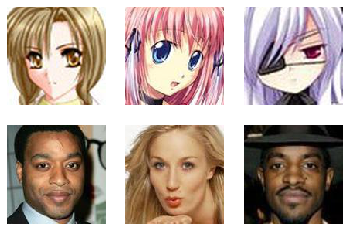

In [0]:
dataA = genA.next()
dataB = genB.next()

n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow((dataA[i] * 255).astype('uint8'))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow((dataB[i] * 255).astype('uint8'))
plt.show()

## Defining CycleGAN model

In [2]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-4cs9i5eg
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4cs9i5eg
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=73d8e283a206a230b0215fbf628639823a3203042e3538198ecab06d5d3f7beb
  Stored in directory: /tmp/pip-ephem-wheel-cache-16rgg0t3/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
from keras.losses import mae
from keras import backend as K
import time
import numpy as np

In [7]:
def my_mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

In [8]:
def better_cycle_loss_wrapper(output_d_id, output_d, alpha):
    def better_cycle_loss(y_true, y_pred):
        return alpha * my_mae(output_d_id, output_d) + (1 - alpha) * my_mae(y_true, y_pred)
    return better_cycle_loss

In [16]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
import os

# define the discriminator model


def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss_weights=[0.5])
    return model


# generator a resnet block


def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3, 3), padding='same',
               kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g


# define the standalone generator model


def define_generator(image_shape, n_resnet=6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3, 3),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3, 3),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3, 3),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3, 3),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


# define a composite model for updating generators by adversarial and cycle loss


def define_composite_model(g_model_1, d_model, g_model_2, image_shape, alpha, cycle_loss_weight=10):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)

    output_d_id = d_model(input_id)
    output_d_gen = d_model(input_gen)

    # forward cycle
    output_f = g_model_2(gen1_out)
    
    output_d_f = d_model(output_f)
    
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    output_d_b  = d_model(output_b)
    
    # define model graph
    model = Model([input_gen, input_id],
                  [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss    
    model.compile(loss=['mse', 'mae', 
                        better_cycle_loss_wrapper(output_d_gen, output_d_f, alpha), 
                        better_cycle_loss_wrapper(output_d_id, output_d_b, alpha)],
                  loss_weights=[1, 5, cycle_loss_weight, cycle_loss_weight],
                  optimizer=opt)
    return model


# select a batch of random samples, returns images and target


def generate_real_samples(gen, n_samples, patch_shape):
    X = gen.next()
    X = (X * 2.) - 1.
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


# generate a batch of images, returns images and targets


def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


# save the generator models to file


def save_models(step, g_model_AtoB, g_model_BtoA, timestamp):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step + 1)
    g_model_AtoB.save(os.path.join(timestamp, filename1))
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step + 1)
    g_model_BtoA.save(os.path.join(timestamp, filename2))
    print('>Saved: %s and %s' % (filename1, filename2))


# generate samples and save as a plot and save the model


def summarize_performance(step, g_model, trainX, name, timestamp, n_samples=4):
    # select a sample of input images
    # plot real images
    pyplot.figure(figsize=(20, 15))
    for i in range(n_samples):
        X_in, _ = generate_real_samples(trainX, 1, 0)
        # generate translated images
        X_out, _ = generate_fake_samples(g_model, X_in, 0)
        # scale all pixels from [-1,1] to [0,1]
        X_in = (X_in + 1.) / 2.0
        X_out = (X_out + 1.) / 2.0
        
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[0])
        
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[0])
        
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step + 1))
    pyplot.savefig(os.path.join(timestamp, filename1))
    pyplot.close()


# update image pool for fake images


def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)


def update_alpha_coef(var, new_val):
    print('Updating value:', K.get_value(var))
    K.set_value(var, new_val)

# train cyclegan models
    
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB,
          c_model_BtoA, dataset_size, alpha, cl_weight_variable=None):
    n_epochs, n_batch = 100, 1
    n_patch = d_model_A.output_shape[1]

    datagen = ImageDataGenerator(rescale=1. / 255)

    trainA = datagen.flow_from_directory('data/train/human',
                                         target_size=(128, 128),
                                         batch_size=n_batch,
                                         class_mode=None)

    trainB = datagen.flow_from_directory('data/train/anime',
                                         target_size=(128, 128),
                                         batch_size=n_batch,
                                         class_mode=None)

    poolA, poolB = list(), list()
    bat_per_epo = int(dataset_size / n_batch)
    n_steps = bat_per_epo * n_epochs
    
    timestamp = time.strftime("%Y-%m-%d_%H:%M:%S")
    if not os.path.isdir(timestamp):
        os.mkdir(timestamp)
    
    alphas = np.linspace(0.0, 1.0, num=n_epochs) ** 0.7
    cycle_loss_weights = np.linspace(10.0, 1.0, num=n_epochs) 
    
    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB,
                                                 n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA,
                                                 n_patch)
        
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch(
            [X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch(
            [X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        if (i + 1) % 10 == 0:
            print(
                '> %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' %
                (i + 1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
            
        if (i + 1) % bat_per_epo == 0:
            update_alpha_coef(alpha, alphas[(i+1) // bat_per_epo])
            if cl_weight_variable:
                K.set_value(cl_weight_variable, cycle_loss_weights[(i+1) // bat_per_epo])
            
            print('\t>> Epoch %d' % ((i + 1) // bat_per_epo))
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB', timestamp)
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA', timestamp)
            
        if (i + 1) % (bat_per_epo * 3) == 0:
            save_models(i, g_model_AtoB, g_model_BtoA, timestamp)

In [17]:
image_shape = (128, 128, 3)
alpha = K.variable(0, dtype='float32')
cl_weight_var = K.variable(10.0, dtype='float32')

# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA,
                                      image_shape, alpha, cycle_loss_weight=cl_weight_var)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB,
                                      image_shape, alpha, cycle_loss_weight=cl_weight_var)

## Training model

In [18]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB,
      c_model_BtoA, 1000, alpha)

Found 64086 images belonging to 1 classes.


W0123 14:44:23.415117 140566929692480 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0123 14:44:23.427781 140566929692480 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



Found 63569 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected

> 10, dA[2.135,1.229] dB[1.620,1.638] g[16.761,15.030]
> 20, dA[0.632,0.941] dB[1.238,0.656] g[13.051,12.452]
> 30, dA[0.562,0.625] dB[0.525,0.852] g[12.449,11.299]
> 40, dA[0.277,1.062] dB[0.502,0.273] g[10.488,10.315]
> 50, dA[0.292,0.469] dB[0.562,0.243] g[12.158,10.290]
> 60, dA[0.158,0.378] dB[0.470,0.322] g[8.941,8.699]
> 70, dA[0.326,0.147] dB[0.379,0.364] g[8.779,8.638]
> 80, dA[0.184,0.177] dB[0.143,0.207] g[7.781,7.934]
> 90, dA[0.115,0.613] dB[0.191,0.086] g[8.699,9.117]
> 100, dA[0.044,0.115] dB[0.111,0.146] g[9.876,9.188]
> 110, dA[0.264,0.106] dB[0.124,0.242] g[7.077,7.937]
> 120, dA[0.215,0.347] dB[0.418,0.318] g[10.161,8.820]
> 130, dA[0.075,0.171] dB[0.214,0.199] g[7.928,7.724]
> 140, dA[0.205,0.087] dB[0.104,0.284] g[5.617,6.497]
> 150, dA[0.172,0.057] dB[0.065,0.066] g[8.857,8.964]
> 160, dA[0.229,0.090] dB[0.242,0.179] g[6.924,7.066]
> 170, dA[0.059,0.161] dB[0.135,0.208] g[7.247,6.889]
> 180, dA[0.259,0.103] dB[0.132,0.062] g[7.076,7.170]
> 190, dA[0.112,0.045] dB[

KeyboardInterrupt: 

## Testing model

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


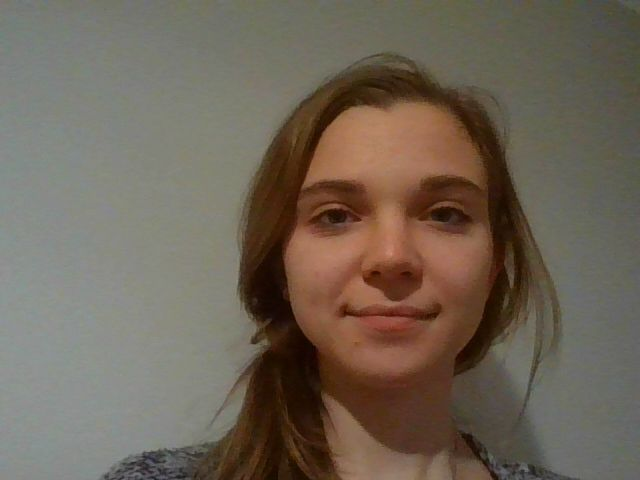

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import expand_dims
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import cv2

# load and prepare training images
def load_image(image_name, img_size=(128, 128), cascade_file = PATH + "haarcascade_frontalface_default.xml"):
    image = cv2.cvtColor(cv2.imread(image_name, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    cascade = cv2.CascadeClassifier(cascade_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    
    faces = cascade.detectMultiScale(gray,
                                     # detector options
                                     scaleFactor = 1.1,
                                     minNeighbors = 5,
                                     minSize = (100, 100))
    
    assert len(faces) > 0, "No face deteted"
    x, y, w, h = faces[0]
    cropped = image[int(y-0.1*h): int(y+1.1*h), int(x-0.1*h): int(x+1.1*h)]
    if cropped.shape != img_size:
        cropped = cv2.resize(cropped, img_size)
    return (cropped - 127.5) / 127.5

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot images row by row
    pyplot.figure(figsize=(15, 7))
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, len(images), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # title
        pyplot.title(titles[i])
    pyplot.show()

In [0]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(PATH + 'g_model_AtoB_007500.h5', cust)
model_BtoA = load_model(PATH + 'g_model_BtoA_007500.h5', cust)

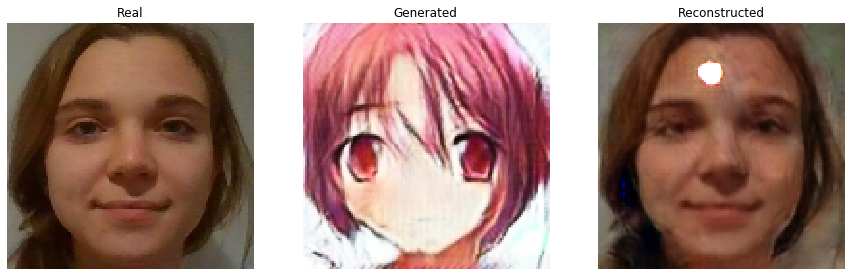

In [0]:
A_real = expand_dims(load_image('photo.jpg'), axis=0)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

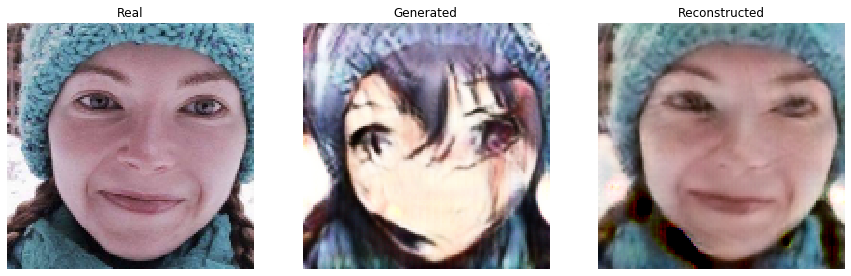

In [0]:
A_real = expand_dims(load_image('julia.jpg'), axis=0)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

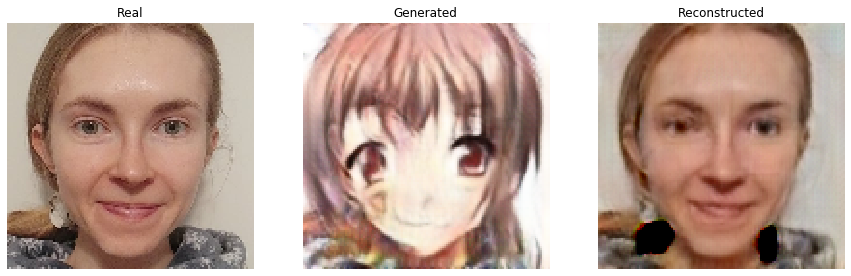

In [0]:
A_real = expand_dims(load_image('julia.jpg'), axis=0)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)